In [ ]:
import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import mw_algorithm as mw

In [2]:
 # ! TO REPLACE WITH YOUR OWN DIRECTORY
script_directory =os.getcwd()

inputs_folder = f"{script_directory}/inputs"
outputs_folder = f"{script_directory}/outputs"

# MW_Protocol - Application to Nemo & deglacial Laurentide ice sheet

The Meltwater Protocol was introduced in [https://doi.org/10.1029/2022PA004451](Romé et al., 2022). It aims to create a transient meltwater discharge forcing file for GCMs from an ice sheet reconstruction. The steps involved are as follows:
 - Converting the ice sheet reconstruction's elevation changes into freshwater discharge.
 - Routing the freshwater discharge to its associated ocean point using a routing map.
 - Regridding the discharge to the GCM ocean grid (NEMO in this case) and adjusting discharge points that overlap with the land-sea mask.
 - Spreading the freshwater discharge over larger regions.
 - Plotting and saving the resulting discharge file.

 This example is using GLAC-1D ice sheet reconstruction and using the NEMO grid.

## Input files

In [3]:
# Ice sheet reconstruction
ds_glac = xr.open_dataset(f"{inputs_folder}/GLAC1DHiceF26.nc")
ds_glac

<xarray.Dataset> Size: 1GB
Dimensions:      (XLONGLOBP5: 720, YLATGLOBP25: 720, T122KP1: 261)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 6kB 180.2 180.8 181.2 ... 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 6kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * T122KP1      (T122KP1) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Data variables:
    HGLOBH       (T122KP1, YLATGLOBP25, XLONGLOBP5) float64 1GB ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D ice thickness Field, Lev Tarasov

In [4]:
# Land sea mask
ds_bathy = xr.open_dataset(f"{inputs_folder}/bathy_20ka.nc")
lsm = xr.where(ds_bathy.bathy_metry.isel(time_counter=0) > 0, 0, 1)
ds_bathy

<xarray.Dataset> Size: 3MB
Dimensions:       (time_counter: 1, y: 800, x: 544)
Coordinates:
  * time_counter  (time_counter) float32 4B 0.0
Dimensions without coordinates: y, x
Data variables:
    bathy_metry   (time_counter, y, x) float64 3MB ...
Attributes:
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1 2]
    DOMAIN_size_global:      [544 800]
    DOMAIN_size_local:       [544 800]
    DOMAIN_position_first:   [1 1]
    DOMAIN_position_last:    [544 800]
    DOMAIN_halo_size_start:  [0 0]
    DOMAIN_halo_size_end:    [0 0]
    DOMAIN_type:             BOX
    history:                 Tue Mar 18 08:54:14 2025: ncks -v bathy_metry me...
    NCO:                     netCDF Operators version 5.3.2 (Homepage = http:...

In [5]:
# Ref NEMO file
ds_ref = xr.open_dataset(f"{inputs_folder}/ANHA4_ReNat_HydroGFD_HBC_runoff_monthly_y2003.nc", decode_times=False)
ds_ref

<xarray.Dataset> Size: 47MB
Dimensions:       (y: 800, x: 544, time_counter: 12)
Coordinates:
  * time_counter  (time_counter) float64 96B 2.009e+04 2.012e+04 ... 2.042e+04
Dimensions without coordinates: y, x
Data variables:
    nav_lon       (y, x) float32 2MB ...
    nav_lat       (y, x) float32 2MB ...
    socoefr       (y, x) float32 2MB ...
    runoff        (time_counter, y, x) float32 21MB ...
    rotemper      (time_counter, y, x) float32 21MB ...
Attributes:
    source:   HYPE ReNat runoff for HydroGFD BaySys run for 1981 to 2019 (13-...

In [6]:
# River drainage map corresponding to the ice sheet reconstruction 
ds_pointer = xr.open_dataset(f'{inputs_folder}/GLAC1DdrainagePointerF26ka.nc')
ds_pointer

<xarray.Dataset> Size: 1GB
Dimensions:      (XLONGLOBP5: 720, YLATGLOBP25: 720, T40H1: 261)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 6kB 180.2 180.8 181.2 ... 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 6kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * T40H1        (T40H1) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Data variables:
    IX           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 541MB ...
    JY           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 541MB ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D drainage Pointer Field, Lev Tarasov

## 1) Conversion - From the ice sheet reconstruction to the freshwater discharge

Inputs:
 - Ice sheet reconstruction

 Outputs:
 - Freshwater discharge for each ice sheet grid cell

In [7]:
ds_fw = mw.hi_to_discharge(ds_glac, flux_unit='kg/s', keep_negative=False)
ds_fw

____ Calculating surface matrix


<xarray.Dataset> Size: 1GB
Dimensions:       (lat: 720, lon: 720, time: 261)
Coordinates:
  * lon           (lon) float64 6kB 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * lat           (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Data variables:
    fw_discharge  (time, lat, lon) float64 1GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    units:        kg/s
    description:  Freshwater discharge derived from the GLAC-1D ice sheet rec...

Text(0.5, 0.98, 'Ice thickness and freshwater discharge at 25ka BP')

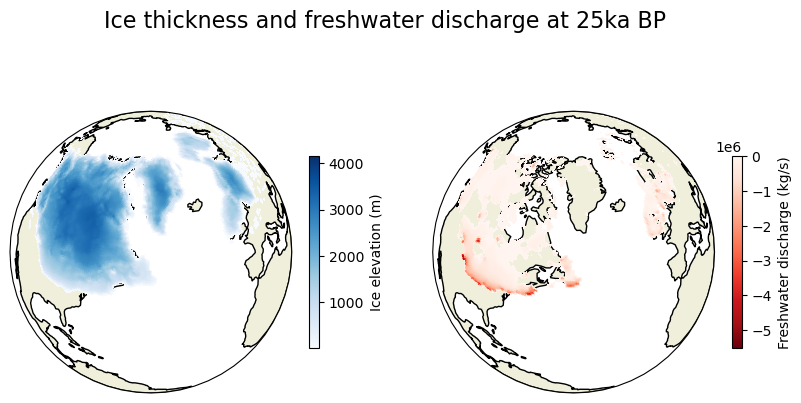

In [8]:
projection_map = ccrs.NearsidePerspective(central_longitude=-50.0, central_latitude=55.0, satellite_height=10000000)
time_step = -25

fig,(axIce, axFw) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(10,5))

thickness = np.where(ds_glac.HGLOBH.sel(T122KP1=time_step).values==0, np.nan, ds_glac.HGLOBH.sel(T122KP1=time_step).values)
cm_ice = axIce.pcolormesh(
    ds_glac.XLONGLOBP5, ds_glac.YLATGLOBP25, thickness, cmap="Blues", transform=ccrs.PlateCarree())
axIce.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
fig.colorbar(mappable=cm_ice, ax=axIce, label="Ice elevation (m)", shrink=0.5)

discharge = np.where(ds_fw.fw_discharge.sel(time=time_step).values==0, np.nan, ds_fw.fw_discharge.sel(time=time_step).values)
cm_fw = axFw.pcolormesh(ds_fw.lon, ds_fw.lat, discharge, cmap='Reds_r', transform=ccrs.PlateCarree())
axFw.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
fig.colorbar(mappable=cm_fw, ax=axFw, label=f"Freshwater discharge ({ds_fw.attrs['units']})", shrink=0.5)

fig.suptitle(f"Ice thickness and freshwater discharge at {-time_step}ka BP", fontsize=16)

In [9]:
# !! Uncomment to save the file
# ds_fw.to_netcdf(f"{outputs_folder}/glac1d_freshwater.nc", mode='w', format='NETCDF4_CLASSIC')

## 2) Routing algorithm

Inputs:
 - Ice sheet meltwater
 - Ice sheet reconstruction (optional, only for maps)
 - River drainage map corresponding to the ice sheet reconstruction

 Outputs:
 - Routed ice sheet meltwater

 **TODO**: Conserve units

In [10]:
ds_fw = xr.open_dataset(f"{outputs_folder}/glac1d_freshwater.nc")
ds_fw

<xarray.Dataset> Size: 1GB
Dimensions:       (time: 261, lat: 720, lon: 720)
Coordinates:
  * lon           (lon) float64 6kB 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * lat           (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Data variables:
    fw_discharge  (time, lat, lon) float64 1GB ...
Attributes:
    units:        kg/s
    description:  Freshwater discharge derived from the GLAC-1D ice sheet rec...

In [11]:
# Pointer file - Indexes to coordinates conversion according to A.Wickaert's notes
IX_lon = ds_pointer.IX.sel(T40H1=-26).values*0.5 - 180.25 + 360
JY_lat = 90.125 - ds_pointer.JY.sel(T40H1=-26).values*0.25 

First, we can test if the routing is working

(lon,lat) [index_lon,index_lat] : (np.float64(275.25), np.float64(47.625)) [(190, 550)] -> (np.float32(286.75), np.float32(38.375)) [(np.float32(213.0), np.float32(513.0))]
(lon,lat) [index_lon,index_lat] : (np.float64(272.75), np.float64(29.375)) [(185, 477)] -> (np.float32(272.75), np.float32(29.375)) [(np.float32(185.0), np.float32(477.0))]
(lon,lat) [index_lon,index_lat] : (np.float64(330.25), np.float64(47.625)) [(300, 550)] -> (np.float32(330.25), np.float32(47.625)) [(np.float32(300.0), np.float32(550.0))]


Text(0.5, 1.0, 'Sample routing points')

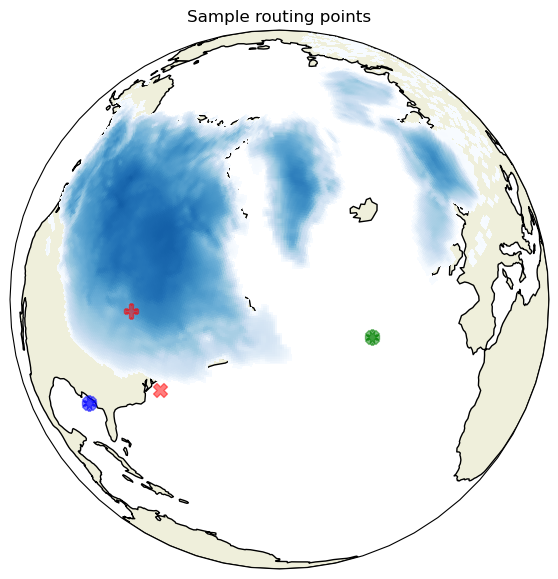

In [12]:
projection_map = ccrs.NearsidePerspective(central_longitude=-50.0, central_latitude=55.0, satellite_height=10000000)
time_step = -25

fig,ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

# axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="binary", alpha=0.8)
lon_glac, lat_glac = ds_glac.XLONGLOBP5.values, ds_glac.YLATGLOBP25.values

points = [(190,550), (185,477), (300,550)]
colors = ['r', 'b', 'g']

# On land
for n in range(len(points)):
    i, j = points[n]
    ax.scatter(lon_glac[i], lat_glac[j], s=100, c=colors[n],
               transform=ccrs.PlateCarree(), zorder=2, alpha=0.5, marker="P")
    ax.scatter(IX_lon[j,i], JY_lat[j,i], s=100, c=colors[n],
               transform=ccrs.PlateCarree(), zorder=2, alpha=0.5, marker="X")
    i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
    print(f"(lon,lat) [index_lon,index_lat] : {lon_glac[i], lat_glac[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")


thickness = np.where(ds_glac.HGLOBH.sel(T122KP1=time_step).values==0, np.nan, ds_glac.HGLOBH.sel(T122KP1=time_step).values)
cm_ice = ax.pcolormesh(ds_glac.XLONGLOBP5, ds_glac.YLATGLOBP25, thickness, 
                       cmap="Blues", zorder=1, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.set_title("Sample routing points")

We then apply this method to the meltwater dataset.

In [13]:
ds_routed = mw.routing(ds_fw, IX_lon, JY_lat)
ds_routed

____ Routing method.
____ No conversion needed, using the input units (kg/s).


<xarray.Dataset> Size: 1GB
Dimensions:       (time: 261, lat: 720, lon: 720)
Coordinates:
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
  * lon           (lon) float64 6kB 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * lat           (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Data variables:
    fw_discharge  (time, lat, lon) float64 1GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    units:        kg/s
    description:  Routed freshwater discharge derived from the GLAC-1D ice sh...

In [14]:
## Processing the dataset for scatterplot

x,y = np.meshgrid(ds_routed.lon, ds_routed.lat)
routed_fw= xr.where(ds_routed.fw_discharge==0, np.nan, ds_routed.fw_discharge)

Text(0.5, 0.98, 'Routed GLAC-1D freshwater discharge at 25ka BP')

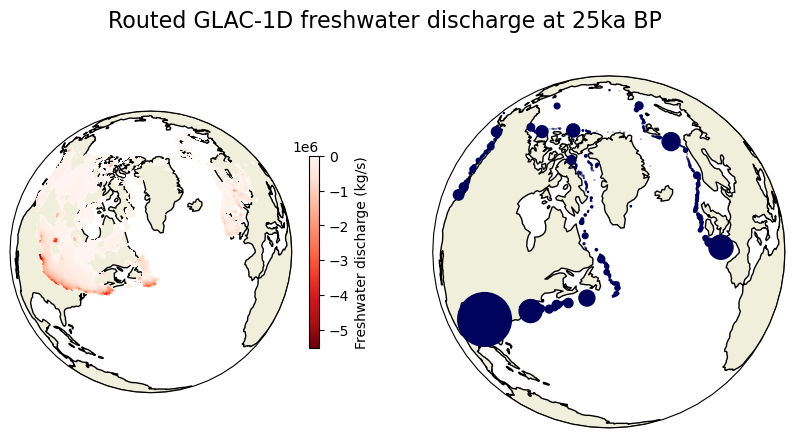

In [15]:
projection_map = ccrs.NearsidePerspective(central_longitude=-50.0, central_latitude=55.0, satellite_height=10000000)
time_step = -25

fig,(axFw, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(10,5))

discharge = np.where(ds_fw.fw_discharge.sel(time=time_step).values==0, np.nan, ds_fw.fw_discharge.sel(time=time_step).values)
cm_fw = axFw.pcolormesh(ds_fw.lon, ds_fw.lat, discharge, cmap='Reds_r', transform=ccrs.PlateCarree())
axFw.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
fig.colorbar(mappable=cm_fw, ax=axFw, label=f"Freshwater discharge ({ds_fw.attrs['units']})", shrink=0.5)

axRouted.scatter(x,y,s=-1e-6*routed_fw.sel(time=time_step),c='xkcd:dark blue',
                 transform=ccrs.PlateCarree(), zorder=1)
axRouted.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

fig.suptitle(f"Routed GLAC-1D freshwater discharge at {-time_step}ka BP", fontsize=16)

In [ ]:
# !! Uncomment to save the file
# ds_routed.to_netcdf(f"{outputs_folder}/glac1d_freshwater_routed.nc", mode='w', format='NETCDF4_CLASSIC')

## 3) Regridding - Fitting the discharge to the NEMO grid

Inputs:
 - Routed discharge
 - NEMO grid

 Outputs:
 - Routed discharge on NEMO grid

There are two ways to do the regridding: 
 - The conservative method picks the closest grid cell to the previous cell and redirect the water in this cell
 - The distributive method simply regrids the previous grid on the new grid.

### Distributive method

In [7]:
ds_routed = xr.open_dataset(f"{outputs_folder}/glac1d_freshwater_routed.nc")
ds_routed

<xarray.Dataset> Size: 1GB
Dimensions:       (time: 261, lat: 720, lon: 720)
Coordinates:
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
  * lon           (lon) float64 6kB 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * lat           (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Data variables:
    fw_discharge  (time, lat, lon) float64 1GB ...
Attributes:
    units:        kg/s
    description:  Routed freshwater discharge derived from the GLAC-1D ice sh...

In [8]:
ds_fw_grid = ds_routed.rename({'lon': 'longitude', 'lat': 'latitude'})
ds_nemo_grid = ds_ref.rename({'nav_lon': 'longitude', 'nav_lat': 'latitude'})

Chose one algorithm between 'bilinear', 'nearest_s2d' and 'nearest_d2s'. 
For more infomation, please refer to this tutorial : [Comparison of six regridding algorithms](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html)

When converting between a rectilinear grid to a finer rectilinear grid or a curvilinear grid, it is recomended to chose 'nearest_d2s' to avoid the spreading of the signal, although bear in mind that this may be slower.

TODO: comparison of the three algorithms

In [ ]:
method = 'nearest_d2s'  # XESMF regridding method.
ds_fw_nemo = mw.regridding(ds_fw_grid, ds_nemo_grid, method=method, reuse_weights=True)
ds_fw_nemo

__ Regridding method using nearest_d2s method.
____ Creating the regridder at regridder_nearest_d2s_GLAC-1D_NEMO.nc.
____ Regridding the freshwater discharge.
____ Scaling factor (mean): 1.00


<xarray.Dataset> Size: 912MB
Dimensions:       (time: 261, y: 800, x: 544)
Coordinates:
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Dimensions without coordinates: y, x
Data variables:
    fw_discharge  (time, y, x) float64 909MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lon       (y, x) float32 2MB -98.25 -98.0 -97.75 ... 103.6 103.4 103.2
    nav_lat       (y, x) float32 2MB -20.08 -20.08 -20.08 ... 54.44 54.38 54.31
Attributes:
    units:        kg/s
    description:  Routed freshwater discharge derived from the GLAC-1D ice sh...

Text(0.5, 0.98, 'Routed GLAC-1D freshwater discharge at 25ka BP on NEMO grid')

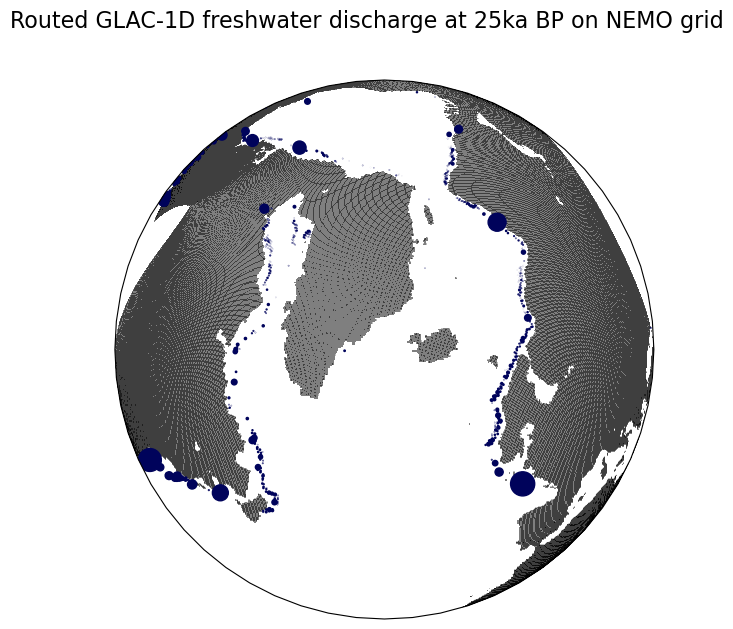

In [11]:
time_step = -25

projection = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=65, satellite_height=3000000)
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7), subplot_kw={'projection':projection})

ax.pcolormesh(ds_ref.nav_lon, ds_ref.nav_lat, lsm, cmap="binary", alpha=0.5,
                     transform=ccrs.PlateCarree())

ax.scatter(ds_ref.nav_lon, ds_ref.nav_lat,s=-1e-6*ds_fw_nemo.fw_discharge.sel(time=time_step),c='xkcd:dark blue',
           transform=ccrs.PlateCarree(), zorder=1)

fig.suptitle(f"Routed GLAC-1D freshwater discharge at {-time_step}ka BP on NEMO grid", fontsize=16)

In [ ]:
# !! Uncomment to save the file
# ds_fw_nemo.to_netcdf(f"{outputs_folder}/glac1d_freshwater_nemo.nc", mode='w', format='NETCDF4_CLASSIC')

## 4) Overlapping - Shift discharge points from land to ocean

Inputs:
 - Routed discharge on the NEMO grid
 - Land-sea mask on NEMO grid

 Outputs:
 - Shifted discharge on NEMO grid

 **TODO** : 
 - Handle time dimension
 - Units and tests (sum of all discharge stays the same)

Note that this step is not necessary as the collection method can capture, if the boxes are well defined, the discharge on clost to the coastal cells. This is, however, a good way to make sure that no discharge is lost in the process.

In [7]:
ds_fw_nemo = xr.open_dataset(f"{outputs_folder}/glac1d_freshwater_nemo.nc", format='NETCDF4_CLASSIC')
ds_fw_nemo

<xarray.Dataset> Size: 912MB
Dimensions:       (time: 261, y: 800, x: 544)
Coordinates:
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Dimensions without coordinates: y, x
Data variables:
    fw_discharge  (time, y, x) float64 909MB ...
    nav_lon       (y, x) float32 2MB ...
    nav_lat       (y, x) float32 2MB ...
Attributes:
    units:        kg/s
    description:  Routed freshwater discharge derived from the GLAC-1D ice sh...

In [35]:
fw_discharge = ds_fw_nemo.fw_discharge
n_j, n_i = fw_discharge[0].shape

lsm_expanded = lsm.expand_dims({'time': fw_discharge.shape[0]})
lsm_expanded = lsm_expanded.assign_coords(time=ds_fw_nemo.time)
overlapping_mask = np.logical_and(fw_discharge!=0, lsm_expanded == 1)

shifted_fw = fw_discharge * overlapping_mask


In [31]:
np.nanmax(fw_discharge.isel(time=10).where(fw_discharge.isel(time=10) != 0))

np.float64(-0.6195014495729286)

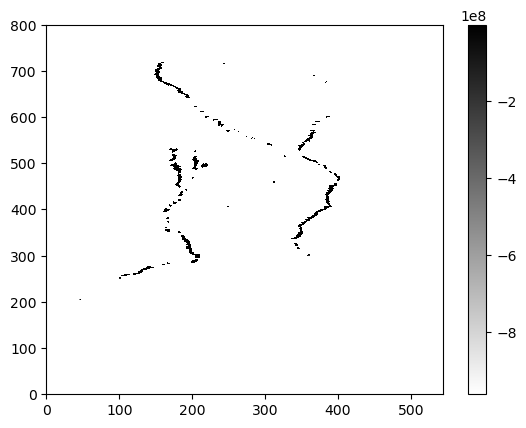

In [ ]:
plt.pcolormesh(fw_discharge.isel(time=10).where(fw_discharge.isel(time=10) != 0), cmap='binary')
plt.colorbar()

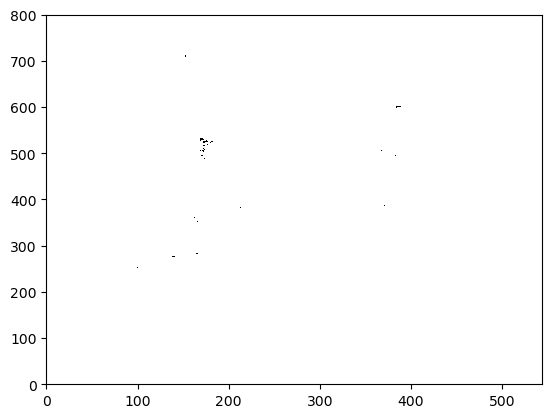

In [40]:
plt.pcolormesh(overlapping_mask.isel(time=30).values, cmap='binary')

In [43]:
np.count_nonzero(overlapping_mask.isel(time=40).values)

167

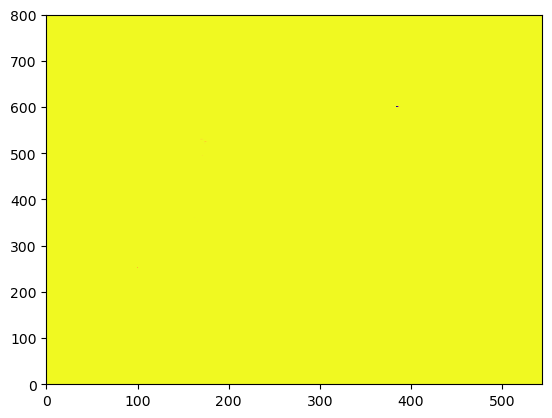

In [39]:
plt.pcolormesh(shifted_fw.isel(time=20).values, cmap='plasma')

In [ ]:
def overlapping(ds_fw, lsm, radius_max=10, verbose=False):
    """
    Shift the mask points overlapping the land mask to the closet sea point.
    :param ds_fw: Dataset containing the flux mask.
    :param lsm: Land sea mask.
    :param radius_max: Maximum radius for the closest sea points. Default is 10.
    :param verbose: Verbose mode. Default is True.
    :return: Processed flux mask [y*x].
    """

    fw_discharge  = ds_fw.fw_discharge.values
    source_units = ds_fw.attrs.get('units')

    if source_units in ['kg/s', 'Sv', 'm3/s']:
        output_units = source_units
        print(f"____ No conversion needed, using the input units ({source_units}).")
    else:
        raise ValueError(f"____ OVerlapping algorithm only works with 'kg/s', 'Sv' or 'm3/s'.")
    
    n_j, n_i = fw_discharge[0].shape

    lsm_expanded = lsm.expand_dims({'time': fw_discharge.shape[0]})
    lsm_expanded = lsm_expanded.assign_coords(time=ds_fw.time)
    overlapping_mask = np.logical_and(fw_discharge!=0, lsm_expanded == 1)
    
    shifted_fw = fw_discharge * ~overlapping_mask

    def sea_neighbours(i, j):
        """
        Find the closest sea neighbours for a point (j, i).
        """
        for radius in range(1, radius_max + 1):
            i_offsets, j_offsets = range(-radius, radius + 1), range(-radius, radius + 1)
            for i_offset in i_offsets:
                for j_offset in j_offsets:
                    i_test, j_test = (i + i_offset) % n_i, min(max(j + j_offset, 0), n_j - 1)
                    if lsm[j_test, i_test] == 0:
                        return [(i_test, j_test)], radius
        print(f"____ Warning: Radius max reached for ({i}, {j})")
        return [], radius_max

    for t in range(overlapping_mask.shape[0]):
        for j, i in np.argwhere(overlapping_mask[t].values):
            sea_points, radius = sea_neighbours(i, j)
            if verbose:
                print(f"____ Shifted (t={t}, {i}, {j}): {fw_discharge[t, j, i]} -> {sea_points} (Radius {radius})")
            for i_sea, j_sea in sea_points:
                shifted_fw[t, j_sea, i_sea] += fw_discharge[t, j, i] / len(sea_points)

    # Create the routed dataset
    ds_shifted = xr.Dataset(
        {
            "fw_discharge": (["time", "y", "x"], shifted_fw.data)
        },
        coords={
            "time": ds_fw.time,
        }
    )

    return ds_shifted.assign_attrs(
        {'units':output_units, 
         'description': f"Shifted freshwater discharge derived from the {"GLAC-1D"} ice sheet reconstruction"})


SyntaxError: f-string: expecting '}' (2665540751.py, line 62)

In [8]:
ds_shifted = mw.overlapping(ds_fw_nemo, lsm, radius_max=2, verbose=False)
ds_shifted

____ No conversion needed, using the input units (kg/s).
____ Warning: Radius max reached for (172, 524)
____ Warning: Radius max reached for (173, 524)
____ Warning: Radius max reached for (174, 524)
____ Warning: Radius max reached for (171, 525)
____ Warning: Radius max reached for (172, 525)
____ Warning: Radius max reached for (173, 525)
____ Warning: Radius max reached for (174, 525)
____ Warning: Radius max reached for (175, 525)
____ Warning: Radius max reached for (176, 525)
____ Warning: Radius max reached for (170, 526)
____ Warning: Radius max reached for (171, 526)
____ Warning: Radius max reached for (172, 526)
____ Warning: Radius max reached for (173, 526)
____ Warning: Radius max reached for (174, 526)
____ Warning: Radius max reached for (175, 526)
____ Warning: Radius max reached for (176, 526)
____ Warning: Radius max reached for (177, 526)
____ Warning: Radius max reached for (169, 527)
____ Warning: Radius max reached for (170, 527)
____ Warning: Radius max reache

TypeError: Variable 'fw_discharge': Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

Text(0.5, 0.98, 'Routed GLAC-1D freshwater discharge at 25ka BP on NEMO grid')

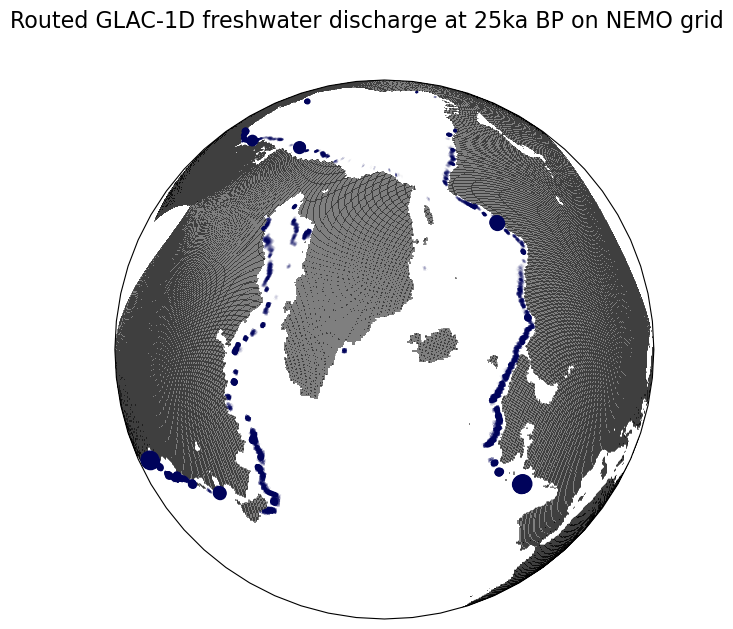

In [ ]:
time_step = -25
projection = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=65, satellite_height=3000000)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7), subplot_kw={'projection':projection})

ax.pcolormesh(ds_ref.nav_lon, ds_ref.nav_lat, lsm, cmap="binary", alpha=0.5,
                     transform=ccrs.PlateCarree())

ax.scatter(ds_ref.nav_lon, ds_ref.nav_lat,s=-1e-6*ds_shifted.sel(time=time_step),c='xkcd:dark blue',
           transform=ccrs.PlateCarree(), zorder=1)

fig.suptitle(f"Routed GLAC-1D freshwater discharge at {-time_step}ka BP on NEMO grid", fontsize=16)

In [34]:
# !! Uncomment to save the file
ds_shifted.to_netcdf(f"{outputs_folder}/glac1d_freshwater_nemo_shifted.nc", mode='w', format='NETCDF4_CLASSIC')

NameError: name 'ds_shifted' is not defined

## 5) Spreading - Collecting and spreading meltwater

Inputs:
 - Routed discharge on the NEMO grid (potentially shifted - Has to be kg/s, m3/s or Sv)
 - Collection Boxes JSON
 - Spreading mw.mw.Regions JSON 
 - Land-sea mask on NEMO grid

 Outputs:
 - Spread discharge

 **TODO** Finish this to create mask

In [11]:
ds_shifted_nemo = xr.open_dataset(f"{outputs_folder}/glac1d_freshwater_nemo_shifted.nc", decode_times=False)
ds_shifted_nemo

<xarray.Dataset> Size: 909MB
Dimensions:       (time: 261, y: 800, x: 544)
Coordinates:
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
    time_counter  float32 4B ...
Dimensions without coordinates: y, x
Data variables:
    fw_discharge  (time, y, x) float64 909MB ...

In [10]:
grid_nemo = mw.Grid(
    ds_ref.nav_lon.values,
    ds_ref.nav_lat.values,
    ds_bathy)

In [11]:
## Import collection boxes from JSON file

collection_boxes = mw.get_collection_boxes(f"{inputs_folder}/collection_boxes.json", grid_nemo)
grouped_boxes = mw.group_collection_box(collection_boxes)
collection_boxes

{'USECoast1': <mw_algorithm.CollectionBox at 0x7fea441c2d30>,
 'USECoast2': <mw_algorithm.CollectionBox at 0x7fea441c2be0>,
 'USECoast3': <mw_algorithm.CollectionBox at 0x7fea441c2430>,
 'USECoast4': <mw_algorithm.CollectionBox at 0x7fea441c2d60>,
 'USECoast5': <mw_algorithm.CollectionBox at 0x7fea441c2af0>,
 'USECoast6': <mw_algorithm.CollectionBox at 0x7fea44163be0>,
 'GrArc1': <mw_algorithm.CollectionBox at 0x7fea441634f0>,
 'NAMArc1': <mw_algorithm.CollectionBox at 0x7fea44163fd0>,
 'NAMArc2': <mw_algorithm.CollectionBox at 0x7fea441638e0>,
 'NAMArc3': <mw_algorithm.CollectionBox at 0x7fea44163f10>,
 'NAMArc4': <mw_algorithm.CollectionBox at 0x7fea441639a0>,
 'NAMArc5': <mw_algorithm.CollectionBox at 0x7fea44163850>,
 'NWTerr1': <mw_algorithm.CollectionBox at 0x7fea44163910>,
 'NWTerr2': <mw_algorithm.CollectionBox at 0x7fea44163520>,
 'GrLakes1': <mw_algorithm.CollectionBox at 0x7fea441635b0>,
 'GoM1': <mw_algorithm.CollectionBox at 0x7fea441694c0>,
 'EPac1': <mw_algorithm.Collect

In [12]:
spreading_regions = mw.get_spreading_regions(f"{inputs_folder}/spreading_regions.json")
spreading_regions

{'US_East_Coast': {'collection_boxes': ['USECoast1',
   'USECoast2',
   'USECoast3',
   'USECoast4',
   'USECoast5',
   'USECoast6',
   'GrLakes1'],
  'spreading_boxes': ['USECoast1',
   'USECoast2',
   'USECoast3',
   'USECoast4',
   'USECoast4',
   'USECoast5']},
 'Greenland_Arctic': {'collection_boxes': ['GrArc1'],
  'spreading_boxes': ['GrArc1']},
 'N_American_Arctic': {'collection_boxes': ['NAMArc1',
   'NAMArc2',
   'NAMArc3',
   'NAMArc4',
   'NAMArc5',
   'NWTerr1',
   'NWTerr2'],
  'spreading_boxes': ['NAMArc1', 'NAMArc2', 'NAMArc3', 'NAMArc4']},
 'Gulf_of_Mexico': {'collection_boxes': ['GoM1'], 'spreading_boxes': ['GoM1']},
 'East_Pacific': {'collection_boxes': ['EPac1',
   'EPac2',
   'EPac3',
   'EPac4',
   'EPac5'],
  'spreading_boxes': ['EPac1', 'EPac2', 'EPac3', 'EPac4', 'EPac5']},
 'Russia_Pacific': {'collection_boxes': ['RussPac1'],
  'spreading_boxes': ['RussPac1']},
 'LabradorSea_BaffinBay': {'collection_boxes': ['BafLab1',
   'BafLab2',
   'BafLab3',
   'HudBay1',
 

### Plotting Collection boxes and spreading regions

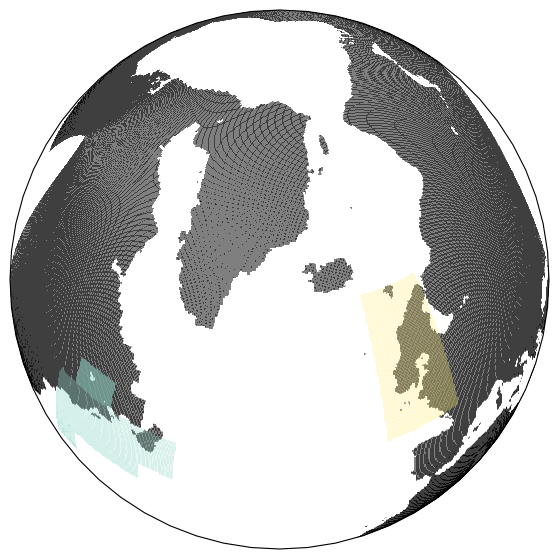

In [14]:
# Only collection boxes

projection = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=65, satellite_height=3000000)
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7), subplot_kw={'projection':projection})

ax.pcolormesh(ds_ref.nav_lon, ds_ref.nav_lat, lsm, cmap="binary", alpha=0.5,
                     transform=ccrs.PlateCarree())

# regions_to_plot = list(grouped_boxes.keys())
regions_to_plot = ['USA East Coast', 'UK Atlantic']

# Assigning autoamatic colors to each region
cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in np.linspace(0, 1, len(regions_to_plot))]
# cmap = plt.get_cmap('rainbow')
# colors = [cmap(i) for i in np.linspace(0, 1, len(regions_to_plot))]


for idr, region in enumerate(regions_to_plot):
    for box in grouped_boxes[region]:
        # Get the polygon for the box
        polygon = box.get_box()
        # Create the mask for this box (True where inside the box)
        mask = box.get_mask()
        # Plot the mask as a colored overlay (alpha for transparency)
        ax.pcolormesh(
            ds_ref.nav_lon, ds_ref.nav_lat, np.where(mask,1,np.nan), 
            cmap=mcolors.ListedColormap([colors[idr]]),
            alpha=0.2, transform=ccrs.PlateCarree()
        )



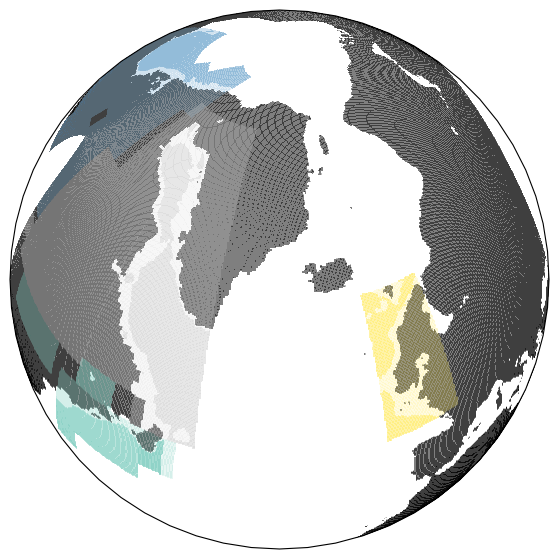

In [16]:
# Collection boxes and spreading regions:

# Only collection boxes

projection = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=65, satellite_height=3000000)
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7), subplot_kw={'projection':projection})

ax.pcolormesh(ds_ref.nav_lon, ds_ref.nav_lat, lsm, cmap="binary", alpha=0.5,
                     transform=ccrs.PlateCarree())

# regions_to_plot = list(spreading_regions.keys())
regions_to_plot = ['US_East_Coast','N_American_Arctic','LabradorSea_BaffinBay', 'UK_Atlantic']

# Assigning autoamatic colors to each region
cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in np.linspace(0, 1, len(regions_to_plot))]


for idr, region in enumerate(regions_to_plot):

    for box in spreading_regions[region]['collection_boxes']:
        # Get the polygon for the box
        polygon = collection_boxes[box].get_box()
        # Create the mask for this box (True where inside the box)
        mask = collection_boxes[box].get_mask()
        # Plot the mask as a colored overlay (alpha for transparency)
        ax.pcolormesh(
            ds_ref.nav_lon, ds_ref.nav_lat, np.where(mask,1,np.nan), 
            cmap=mcolors.ListedColormap([colors[idr]]),
            alpha=0.2, transform=ccrs.PlateCarree()
        )

    for box in spreading_regions[region]['spreading_boxes']:
        # Get the polygon for the box
        polygon = collection_boxes[box].get_box()
        # Create the mask for this box (True where inside the box)
        mask = np.logical_and(collection_boxes[box].get_mask(), grid_nemo.get_depth_mask(depth=500))
        # Plot the mask as a colored overlay (alpha for transparency)
        ax.pcolormesh(
            ds_ref.nav_lon, ds_ref.nav_lat, np.where(mask,1,np.nan), 
            cmap=mcolors.ListedColormap([colors[idr]]),
            alpha=0.5, transform=ccrs.PlateCarree()
        )


### Spreading algorithm

In [17]:
ds_fw = xr.open_dataset(f"{outputs_folder}/glac1d_freshwater_nemo.nc", format='NETCDF4_CLASSIC')
ds_fw

<xarray.Dataset> Size: 912MB
Dimensions:       (time: 261, y: 800, x: 544)
Coordinates:
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Dimensions without coordinates: y, x
Data variables:
    fw_discharge  (time, y, x) float64 909MB ...
    nav_lon       (y, x) float32 2MB ...
    nav_lat       (y, x) float32 2MB ...

In [18]:
discharge_spread = mw.spreading(ds_fw, collection_boxes, spreading_regions, grid_nemo)
discharge_spread = discharge_spread.where(discharge_spread != 0)
discharge_spread

Processing region: US_East_Coast
Processing region: Greenland_Arctic
Processing region: N_American_Arctic
Processing region: Gulf_of_Mexico
Processing region: East_Pacific
Processing region: Russia_Pacific
Processing region: LabradorSea_BaffinBay
Processing region: Atlantic_GreenlandIceland
Processing region: EastGreenland_Iceland
Processing region: EastIceland
Processing region: UK_Atlantic
Processing region: Eurasian_GINSeas
Processing region: South_Iceland
Processing region: Siberian_Arctic
Processing region: Eurasian_Arctic
Processing region: Mediterranean
Processing region: Patagonia_Atlantic
Processing region: Patagonia_Pacific
Processing region: NorthNewZealand_Pacific
Processing region: SouthNewZealand_Pacific
Processing region: Antarctica_RossSea
Processing region: Antarctica_AmundsenSea
Processing region: Antarctica_WeddellSea
Processing region: Antarctica_RiiserLarsonSea
Processing region: Antarctica_DavisSea


<xarray.DataArray 'fw_discharge' (time: 261, y: 800, x: 544)> Size: 909MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.3 -0.2 -0.1 0.0
  * y        (y) int64 6kB 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
  * x        (x) int64 4kB 0 1 2 3 4 5 6 7 8 ... 536 537 538 539 540 541 542 543

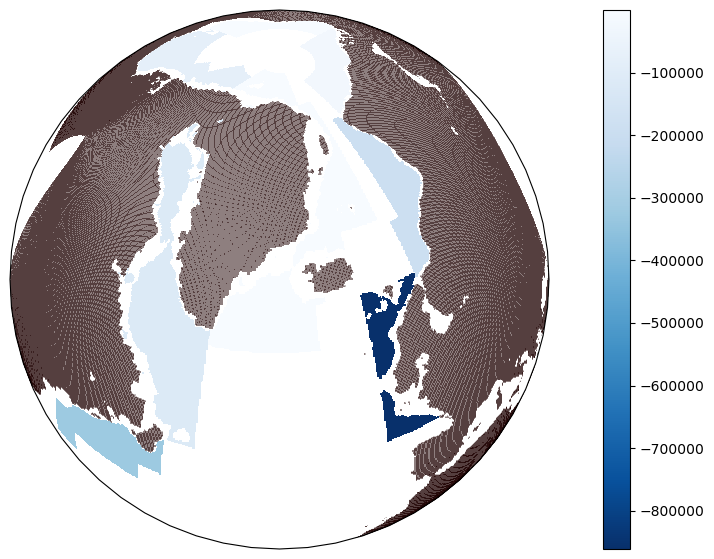

In [21]:
projection = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=65, satellite_height=3000000)
time_step = -25

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7), subplot_kw={'projection':projection})

ax.pcolormesh(ds_ref.nav_lon, ds_ref.nav_lat, lsm, cmap="pink_r", alpha=0.5,
                     transform=ccrs.PlateCarree())


cm = ax.pcolormesh(ds_ref.nav_lon, ds_ref.nav_lat, discharge_spread.sel(time=time_step), 
              cmap='Blues_r', transform=ccrs.PlateCarree())
plt.colorbar(cm)

In [22]:
# !! Uncomment to save the file
discharge_spread.to_dataset().to_netcdf(f"{outputs_folder}/glac1d_freshwater_nemo_spread.nc", mode='w', format='NETCDF4_CLASSIC')

## 6) Saving - To input file

### NEMO file

In [7]:
ds_fw_final = xr.open_dataset(f"{outputs_folder}/glac1d_freshwater_nemo_spread.nc", format='NETCDF4_CLASSIC')
ds_fw_final

<xarray.Dataset> Size: 909MB
Dimensions:       (time: 261, y: 800, x: 544)
Coordinates:
  * time          (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
  * y             (y) int32 3kB 0 1 2 3 4 5 6 7 ... 793 794 795 796 797 798 799
  * x             (x) int32 2kB 0 1 2 3 4 5 6 7 ... 537 538 539 540 541 542 543
Data variables:
    fw_discharge  (time, y, x) float64 909MB ...

In [8]:
ds_ref

<xarray.Dataset> Size: 47MB
Dimensions:       (y: 800, x: 544, time_counter: 12)
Coordinates:
  * time_counter  (time_counter) float64 96B 2.009e+04 2.012e+04 ... 2.042e+04
Dimensions without coordinates: y, x
Data variables:
    nav_lon       (y, x) float32 2MB ...
    nav_lat       (y, x) float32 2MB ...
    socoefr       (y, x) float32 2MB ...
    runoff        (time_counter, y, x) float32 21MB ...
    rotemper      (time_counter, y, x) float32 21MB ...
Attributes:
    source:   HYPE ReNat runoff for HydroGFD BaySys run for 1981 to 2019 (13-...

In [9]:
# Add conversion!!

ds_final_nemo = xr.Dataset(
    {
        "nav_lon": (["y", "x"], ds_ref.nav_lon.data),
        "nav_lat": (["y", "x"], ds_ref.nav_lat.data),
        "socoefr": (["y", "x"], ds_ref.socoefr.data),
        "runoff": (["time", "y", "x"], ds_fw_final.fw_discharge.data),
        "rotemper": (["time", "y", "x"], ds_ref.rotemper.isel(time_counter=0).expand_dims(time=ds_fw_final.time).data),
    },
    coords={
        "time": ds_fw_final.time,
        "y": ds_fw_final.y,
        "x": ds_fw_final.x,
    },
    attrs=ds_fw_final.attrs
)

ds_final_nemo

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 800, x: 544, time: 261)
Coordinates:
  * time      (time) float64 2kB -26.0 -25.9 -25.8 -25.7 ... -0.3 -0.2 -0.1 0.0
  * y         (y) int32 3kB 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
  * x         (x) int32 2kB 0 1 2 3 4 5 6 7 ... 536 537 538 539 540 541 542 543
Data variables:
    nav_lon   (y, x) float32 2MB -98.25 -98.0 -97.75 -97.5 ... 103.6 103.4 103.2
    nav_lat   (y, x) float32 2MB -20.08 -20.08 -20.08 ... 54.44 54.38 54.31
    socoefr   (y, x) float32 2MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    runoff    (time, y, x) float64 909MB nan nan nan nan nan ... nan nan nan nan
    rotemper  (time, y, x) float32 454MB -999.0 -999.0 -999.0 ... -999.0 -999.0